In [1]:
import sys
from pyspark import SparkContext
from pyspark import StorageLevel
import time
import numpy as np
%matplotlib inline
from matplotlib import pyplot

In [2]:
dataDir='data/clusterdata-2011-2/'

In [3]:
sc = SparkContext("local[4]")

In [4]:
sc.setLogLevel("ERROR")
job_events=sc.textFile(dataDir+'/job_events').map(lambda x:x.split(','))
machine_attributes=sc.textFile(dataDir+'/machine_attributes').map(lambda x:x.split(','))
machine_events=sc.textFile(dataDir+'/machine_events').map(lambda x:x.split(','))
task_events=sc.textFile(dataDir+'/task_events').map(lambda x:x.split(','))
task_contraints=sc.textFile(dataDir+'/task_contraints').map(lambda x:x.split(','))
task_usage=sc.textFile(dataDir+'/task_usage').map(lambda x:x.split(','))

In [60]:
#question 1
"""
1- Load the machine_events data
2- Filter the RDD to remove rows without the information about the CPU
3- Map the data as tuple having this form (machine ID,CPUs)
4- Reduce the RDD to remove the duplication by return one value for each key
5- Map the the data as form (CPUs,1)
6- Reduce the current RDD by CPUs as key and summing the the 1 to get the count of each key
Result: The occurance's number of each CPU
"""
CPUs_count=machine_events\
.filter(lambda x:x[4]!="")\
.map(lambda x:(x[1],x[4]))\
.reduceByKey(lambda x,y:x)\
.map(lambda x:(x[1],1))\
.reduceByKey(lambda x,y:x+y)\
.take(10)

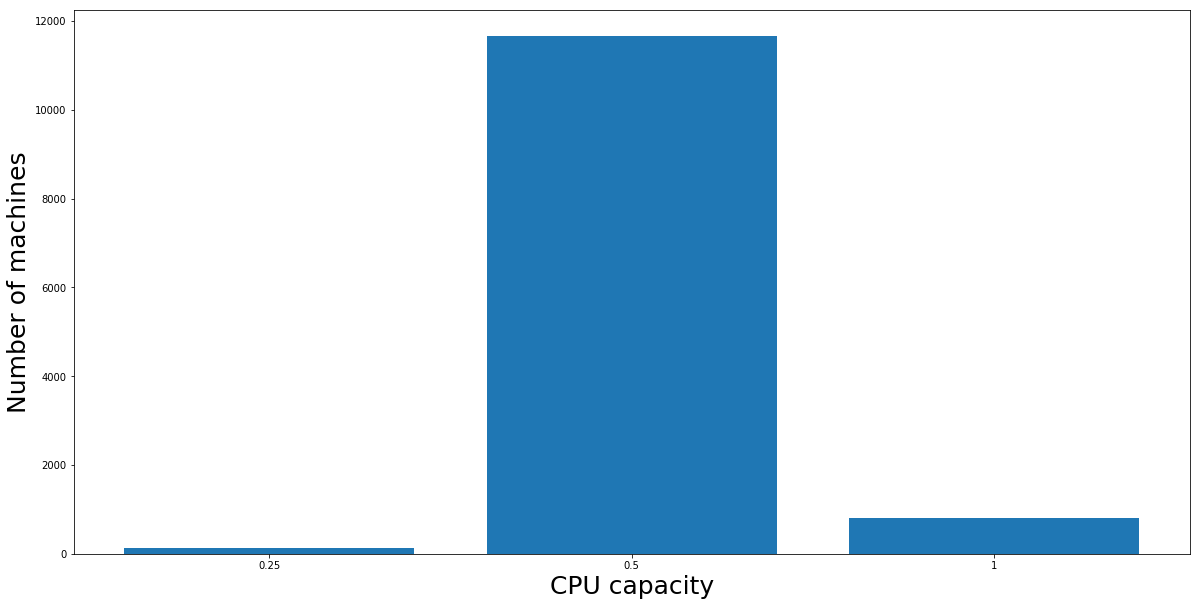

In [43]:
pyplot.figure(figsize=(20,10))
pyplot.bar(*zip(*CPUs_count),align='center') # A bar chart
pyplot.xlabel('CPU capacity',fontsize=25)
pyplot.ylabel('Number of machines',fontsize=25)
pyplot.show()

In [6]:
#question 2
"""
1- Load task_events data
2- Map the data as tuples (job ID,task index)
3- Remove the duplicated tuples
4- Save the RDD as tasks
5- Use the tasks RDD and map the job ID only
6- Remove the duplicated job ID
7- Save the count of this job IDs as number_of_jobs
8- Save the count of rows in tasks that represnt the total number of tasks
9- Calculate the average by dividing the number_of_tasks over number_of_jobs
"""
tasks=task_events\
.map(lambda x:(x[2],x[3]))\
.distinct()
number_of_jobs=tasks\
.map(lambda x:x[0])\
.distinct()\
.count()
number_of_tasks=tasks\
.count()
avg_of_tasks_per_job=number_of_tasks/number_of_jobs
print(avg_of_tasks_per_job)

37.8341959274052


## The result using all data = 37.8341959274052

In [28]:
#question 3
"""
1- Use the task_events RDD
2- Save the count of rows as nb_of_tasks
3- Use the task_events RDD
4- Map the data as tuples (task index,event type)
5- Filter the data to get the event 2(evicted) and 5(killed)
6- Save the count as nb_tasks_evicted_or_killed
7- Divide the nb_tasks_evicted_or_killed over nb_of_tasks to get the average of the tasks evicted or killed
"""
nb_of_tasks=task_events\
.count()
nb_tasks_evicted_or_killed=task_events\
.map(lambda x:(x[3],x[5]))\
.filter(lambda x:x[1]=='5' or x[1]=='2')\
.count()
avg_of_tasks_evicted_or_killed=(nb_tasks_evicted_or_killed/nb_of_tasks)*100
print(avg_of_tasks_evicted_or_killed)

11.209280956024866


## The result using all data = 11.209280956024865

In [58]:
"""
1- Use the job_events RDD
2- Save the count of rows as nb_of_tasks
3- Use the job_events RDD
4- Map the data as tuples (job index,event type)
5- Filter the data to get the event 2(evicted) and 5(killed)
6- Save the count as nb_jobs_evicted_or_killed
7- Divide the nb_jobs_evicted_or_killed over nb_of_jobs to get the average of the jobs evicted or killed
"""
nb_of_job=job_events\
.count()
nb_jobs_evicted_or_killed=job_events\
.map(lambda x:(x[2],x[3]))\
.distinct()\
.filter(lambda x:x[1]=='5' or x[1]=='2')\
.count()
avg_of_jobs_evicted_or_killed=(nb_jobs_evicted_or_killed/nb_of_job)*100
print(avg_of_jobs_evicted_or_killed)

13.535300426091892


## The result using all data = 13.535300426091892

In [48]:
#question 4
"""
1- Use the task_events RDD
2- Map the data as tuple (priority,event type)
3- Group the data by priority
4- For each group calculate the percentage of evicted tasks for all tasks using function f
5- Sort the data by the priority
6- Compute the correlation between the priority and this percentage then plotting the percentages
"""
def f(x):
    """
    Input: list of tuples (priority,event type)
    Output: the percentage of evicted tasks for all tasks
    """
    evic=0
    for i in x:
        if i==2:
            evic=evic+1
    return (float(evic)/len(x))*100

rdd=task_events\
.map(lambda x:(int(x[8]),int(x[5])))\
.groupByKey()\
.mapValues(f)\
.sortByKey()

x=rdd.collect()

corr=np.corrcoef(*zip(*x))


In [49]:
x

[(0, 7.019767395530835),
 (1, 4.057416271306744),
 (2, 1.2955893702681904),
 (3, 4.239401496259352),
 (4, 0.09411385923464861),
 (5, 0.0),
 (6, 0.020402154506192923),
 (7, 0.0),
 (8, 0.3642396178947752),
 (9, 0.3410350154281606),
 (10, 0.5255514110480728),
 (11, 0.0)]

### The result using all data= 
[(0, 7.019767395530835),
 (1, 4.057416271306744),
 (2, 1.2955893702681904),
 (3, 4.239401496259352),
 (4, 0.09411385923464861),
 (5, 0.0),
 (6, 0.020402154506192923),
 (7, 0.0),
 (8, 0.3642396178947752),
 (9, 0.3410350154281606),
 (10, 0.5255514110480728),
 (11, 0.0)]

### We can conclude that there is a big correlation between the priority of the tasks and evicted tasks for all these tasks = -0.7363035

[[ 1.        -0.7363035]
 [-0.7363035  1.       ]]


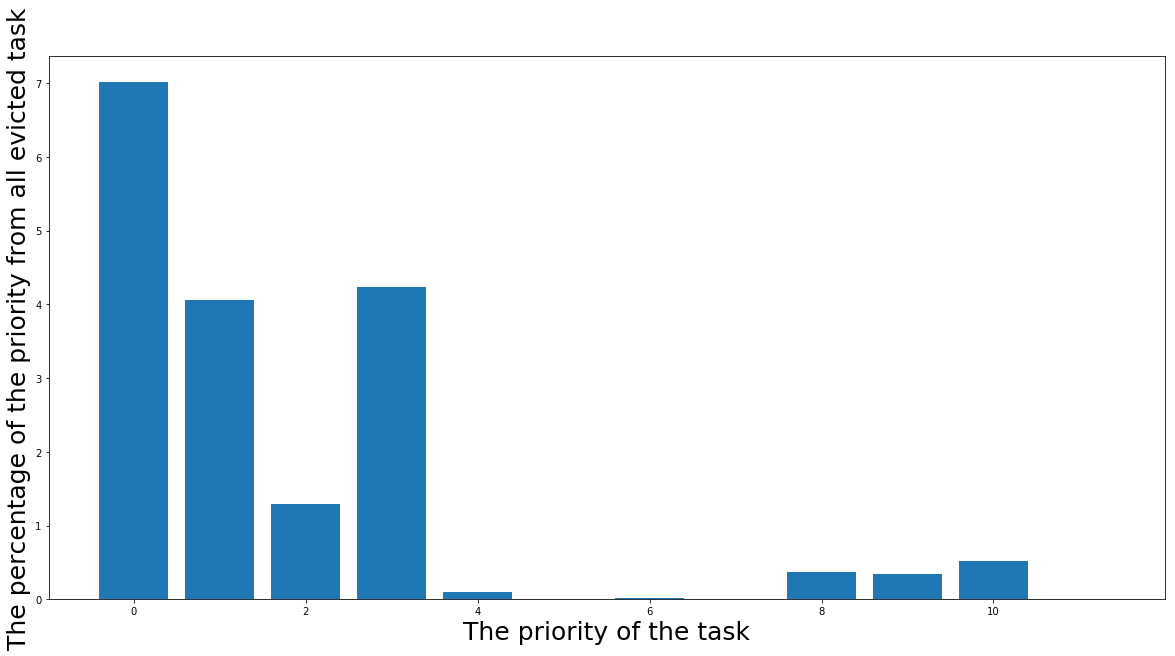

In [52]:
print(corr)
pyplot.figure(figsize=(20,10))
pyplot.bar(*zip(*x),align='center')
pyplot.xlabel('The priority of the task',fontsize=25)
pyplot.ylabel('The percentage of the priority from all evicted task',fontsize=25)
pyplot.show()

In [53]:
#Approach 2

"""
In the first algorithm we compute the percentage of each priority from the evicted tasks, but now we will
the percentage of evicted task from all tasks for each priority
1- Use the task_events RDD
2- Map the data as tuple ((priority,(Job Id,task index)),event type) in RDD all_tasks_events
3- Filter the data and get only the evicted tasks, then map only the (priority,(Job Id,task index))
4- Take the distinct rows and compute the number of evicted task for each priority and save the resukt in map all_evicted_tasks
5- Use all_tasks_events and get only the submit event and take the distinct rows
6- Coumpute the number of tasks with each priority and save the resukt in all_tasks
7- Calculate the percentage of evicted tasks with each priority
"""

all_tasks_events=task_events\
.map(lambda x:((int(x[8]),(x[2],x[3])),int(x[5])))
all_evicted_tasks=all_tasks_events\
.filter(lambda x:x[1]==2)\
.map(lambda x:x[0])\
.distinct()\
.countByKey()
all_tasks=all_tasks_events\
.filter(lambda x:x[1]==0)\
.map(lambda x:x[0])\
.distinct()\
.countByKey()

In [55]:
l=[]
for i in range(12):
    nb_evicted=all_evicted_tasks.get(i)
    nb_of_all_tasks=all_tasks.get(i)
    if(nb_of_all_tasks==None):
        print('The priority {} is not found'.format(i))
        continue
    if(nb_evicted==None):
        print('The percentage of evicted tasks with priority {} is {}'.format(i,0))
        l.append((i,0))
        continue
    print('The percentage of evicted tasks with priority {} is {}'.format(i,(nb_evicted/nb_of_all_tasks)*100))
    l.append((i,(nb_evicted/nb_of_all_tasks)*100))

The percentage of evicted tasks with priority 0 is 17.348312641529954
The percentage of evicted tasks with priority 1 is 9.233915785638096
The percentage of evicted tasks with priority 2 is 1.4412657227965593
The percentage of evicted tasks with priority 3 is 11.295034079844205
The percentage of evicted tasks with priority 4 is 0.28685565505422594
The percentage of evicted tasks with priority 5 is 0
The percentage of evicted tasks with priority 6 is 0.06564715591512135
The percentage of evicted tasks with priority 7 is 0
The percentage of evicted tasks with priority 8 is 0.6553450476096986
The percentage of evicted tasks with priority 9 is 4.769110868022913
The percentage of evicted tasks with priority 10 is 26.44333570919458
The percentage of evicted tasks with priority 11 is 0


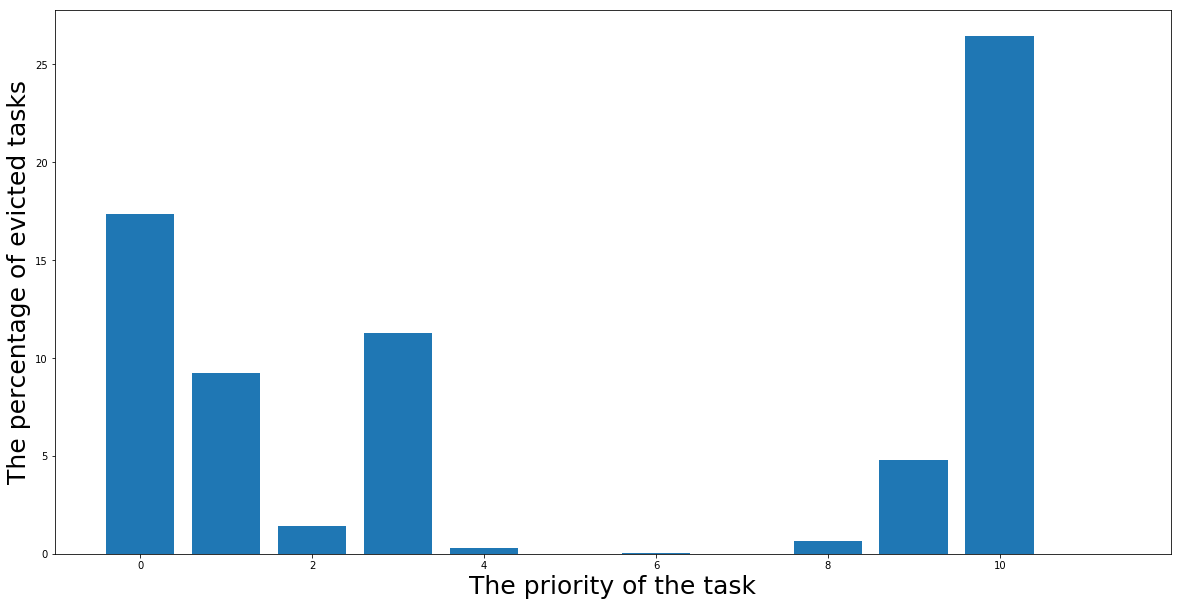

In [57]:
pyplot.figure(figsize=(20,10))
pyplot.bar(*zip(*l),align='center')
pyplot.xlabel('The priority of the task',fontsize=25)
pyplot.ylabel('The percentage of evicted tasks',fontsize=25)
pyplot.show()

### The percentage of evicted tasks with priority 0 is 17.348312641529954
### The percentage of evicted tasks with priority 1 is 9.233915785638096
### The percentage of evicted tasks with priority 2 is 1.4412657227965593
### The percentage of evicted tasks with priority 3 is 11.295034079844205
### The percentage of evicted tasks with priority 4 is 0.28685565505422594
### The percentage of evicted tasks with priority 5 is 0
### The percentage of evicted tasks with priority 6 is 0.06564715591512135
### The percentage of evicted tasks with priority 7 is 0
### The percentage of evicted tasks with priority 8 is 0.6553450476096986
### The percentage of evicted tasks with priority 9 is 4.769110868022913
### The percentage of evicted tasks with priority 10 is 26.44333570919458
### The percentage of evicted tasks with priority 11 is 0

In [22]:
#question 5
"""
1- We calculated the resources used on each machine every timestamp using task_usage RDD
2- Map ((machine ID,start time),(CPU rate,canonical memory usage))
3- Reduce by key and sum the usage to obtain the sum of resources used by all tasks in each timestamp
4- Getting the machine resources informations from machine_events RDD
5- Filter the data to remove the rows that are without informations about resources
6- Reduce by key to remove the duplicated data
7- Computing the free resources of each machine at each timestamp by join the two previous RDD
    and calculate the difference between the total resources and the used resources
8- Maping the value as tuple ((machine ID,start time),(available CPU,available memory))
9- Compute the distribution of tasks over machines at each timestamp using the task_usage RDD
10- Map the data as tuple ((job ID,task index),(machine ID,start time))
11- Get the priority for each task using the task_events RDD
12- Map the data as tuple ((job ID,task index),priority)
13- Inner join the task_distribution_at_each_timestamp RDD with priority_for_each_task RDD
14- Map the data as ((machine ID,start time),priority)
15- Group the last RDD by (machine ID,start time)
16- Apply the function f foreach group to get the percentage of high priority tasks in each machine
17- Inner join the machine_free_resource_at_each_timestamp RDD with priority_distribution_at_each_timestamp RDD
18- Map the data as ((available CPU,available memory),percentage of high priority tasks)
"""
def f(x):
    """
    Input: list of priorities
    Output: percentage of tasks with high priority
    """
    c=0
    for i in x:
        if(i>6):
            c=c+1
        return (c/len(x))*100
resources_used_on_each_machine_every_timestamp=task_usage\
.map(lambda x:((x[4],x[0]),(float(x[5]),float(x[6]))))\
.reduceByKey(lambda x,y:(x[0]+y[0],x[1]+y[1]))\
.map(lambda x: (x[0][0],(x[0][1],x[1])))

machine_recources=machine_events\
.filter(lambda x:x[4]!='' and x[5]!=0)\
.map(lambda x:(x[1],(float(x[4]),float(x[5]))))\
.reduceByKey(lambda x,y:x)

machine_free_resource_at_each_timestamp=machine_recources\
.join(resources_used_on_each_machine_every_timestamp)\
.map(lambda x:((x[0],x[1][1][0]),(x[1][0][0]-x[1][1][1][0],x[1][0][1]-x[1][1][1][1])))

task_distribution_at_each_timestamp=task_usage\
.map(lambda x: ((x[2],x[3]),(x[4],x[0])))

priority_for_each_task=task_events\
.map(lambda x:((x[2],x[3]),float(x[8])))

priority_distribution_at_each_timestamp=task_distribution_at_each_timestamp\
.join(priority_for_each_task)\
.map(lambda x:x[1])\
.groupByKey()\
.mapValues(f)

available_resources_and_priorities=machine_free_resource_at_each_timestamp\
.join(priority_distribution_at_each_timestamp)\
.map(lambda x: x[1])

result=available_resources_and_priorities.collect()

In [34]:
resources,priority=zip(*result)
CPU,memory=zip(*resources)

In [42]:
corr_cpu_priority=np.corrcoef(CPU,priority)
corr_memory_priority=np.corrcoef(memory,priority)

In [43]:
corr_cpu_priority

array([[ 1.        , -0.03432545],
       [-0.03432545,  1.        ]])

In [44]:
corr_memory_priority

array([[ 1.        , -0.05026422],
       [-0.05026422,  1.        ]])

## After computing the correlations between the percentage of tasks with high priority over all task in each timestamp in each machine and the CPU and the memory available in this machine at this timestamp, we conclude that there isn't any correlation between the priority of the tasks and the resources available in the machine

In [5]:
#question 6
"""
To answer to this question, we used two criteria:
1- Comparing between the max usage of the resources and the requested resources.
2- Comparing between the average usage of the resources and the requested resources.

Steps:
1- Use the task_usage RDD
2- Map the data as tuple ((Job Id,task index),(maximum CPU rate,maximum Memory usage)) for the max criteria
    and ((Job Id,task index),(CPU rate,canonical memory usage)) for the average criteria
3- Group the data by the id of task consisting of (Job Id,task index)
4- Map the values for each group using the corresponding function
5- We created another RDD request_resource using task_event RDD to know the requested resources
6- Map the data as tuple ((Job Id,task index),(requested CPU,requested Memory))
"""
def f(x):
    """
    Input: list of tuple(CPU,Memory)
    Output: tuple (max CPU,max Memory)
    """
    cpu,memory=zip(*x)
    cpu=[float(i) for i in cpu]
    memory=[float(i) for i in memory]
    return (max(cpu),max(memory))
def g(x):
    """
    Input: list of tuple(CPU,Memory)
    Output: tuple (average CPU,average Memory)
    """
    cpu,memory=zip(*x)
    cpu=[float(i) for i in cpu]
    memory=[float(i) for i in memory]
    return (sum(cpu)/len(cpu),sum(memory)/len(memory))

max_usage_over_all_time=task_usage\
.map(lambda x:((x[2],x[3]),(x[13],x[10])))\
.groupByKey()\
.mapValues(f)

avg_usage_over_all_time=task_usage\
.map(lambda x:((x[2],x[3]),(x[5],x[6])))\
.groupByKey()\
.mapValues(f)

request_resource=task_events\
.filter(lambda x:x[9]!='' and x[10]!='')\
.map(lambda x:((x[2],x[3]),(float(x[9]),float(x[10]))))



In [94]:
"""
1- Join the two rdd request_resource and max_usage_over_all_time by (Job Id,task index)
2- Map the difference between the two values (request_resource,request_resource-max_usage_over_all_time)
3- Filter the data to get only the positive request_resource-max_usage_over_all_time that used resources less than requested
4- Filter the data to get only that used resources less than the half of that it requested
3- Compute the percentage of tasks that used max CPU significantly less than request and the percentage of tasks
    that used max Memory significantly less than request
"""
difference_between_max_and_request=request_resource.\
join(max_usage_over_all_time)\
.map(lambda x:(x[0],((x[1][0][0],x[1][0][0]-x[1][1][0]),(x[1][0][1],x[1][0][1]-x[1][1][1]))))
percentage_of_tasks_that_used_CPU_significantly_less_than_request=(difference_between_max_and_request.map(lambda x:(x[1][0][0],x[1][0][1]))\
 .filter(lambda x:x[1]>0).filter(lambda x:x[1]/x[0]>0.5).count()/difference_between_max_and_request.count())*100
percentage_of_tasks_that_used_Memory_significantly_less_than_request=(difference_between_max_and_request.map(lambda x:(x[1][1][0],x[1][1][1]))\
 .filter(lambda x:x[1]>0).filter(lambda x:x[1]/x[0]>0.5).count()/difference_between_max_and_request.count())*100

In [ ]:
print("The percentage of tasks that used max CPU significantly less than request is {}\n and the percentage of tasks that used max Memory significantly less than request is {}".format(percentage_of_tasks_that_used_CPU_significantly_less_than_request,percentage_of_tasks_that_used_Memory_significantly_less_than_request))

The percentage of tasks that used max CPU significantly less than request is 42.48637082747936
 and the percentage of tasks that used max Memory significantly less than request is 70.83101752611955


In [6]:
"""
1- Join the two rdd request_resource and max_usage_over_all_time by (Job Id,task index)
2- Map the difference between the two values (request_resource,request_resource-max_usage_over_all_time)
3- Filter the data to get only the positive request_resource-max_usage_over_all_time that used resources less than requested
4- Filter the data to get only that used resources less than the half of that it requested
3- Compute the percentage of tasks that used average CPU significantly less than request and the percentage of tasks
    that used average Memory significantly less than request
"""
difference_between_average_and_request=request_resource\
.join(avg_usage_over_all_time)\
.map(lambda x:(x[0],((x[1][0][0],x[1][0][0]-x[1][1][0]),(x[1][0][1],x[1][0][1]-x[1][1][1]))))
percentage_of_tasks_that_used_CPU_significantly_less_than_request=(difference_between_average_and_request.map(lambda x:x[1][0])\
 .filter(lambda x:x[1]>0).filter(lambda x:x[1]/x[0]>0.5).count()/difference_between_average_and_request.count())*100
percentage_of_tasks_that_used_Memory_significantly_less_than_request=(difference_between_average_and_request.map(lambda x:x[1][1])\
 .filter(lambda x:x[1]>0).filter(lambda x:x[1]/x[0]>0.5).count()/difference_between_average_and_request.count())*100

In [7]:
print("The percentage of tasks that used average CPU significantly less than request is {}\n and the percentage of tasks that used average Memory significantly less than request is {}".format(percentage_of_tasks_that_used_CPU_significantly_less_than_request,percentage_of_tasks_that_used_Memory_significantly_less_than_request))

The percentage of tasks that used average CPU significantly less than request is 68.4613331256954
 and the percentage of tasks that used average Memory significantly less than request is 72.64700762717447


In [77]:
#Addition question
"""
Are there tasks that consume more resources than what they requested? 
"""
"""
To answer to this question, we used two criteria:
1- Comparing between the max usage of the resources and the requested resources.
2- Comparing between the average usage of the resources and the requested resources.

Steps:
1- Use the task_usage RDD
2- Map the data as tuple ((Job Id,task index),(maximum CPU rate,maximum Memory usage)) for the max criteria
    and ((Job Id,task index),(CPU rate,canonical memory usage)) for the average criteria
3- Group the data by the id of task consisting of (Job Id,task index)
4- Map the values for each group using the corresponding function
5- We created another RDD request_resource using task_event RDD to know the requested resources
6- Map the data as tuple ((Job Id,task index),(requested CPU,requested Memory))
"""
def f(x):
    """
    Input: list of tupe(CPU,Memory)
    Output: tuple (max CPU,max Memory)
    """
    cpu,memory=zip(*x)
    cpu=[float(i) for i in cpu]
    memory=[float(i) for i in memory]
    return (max(cpu),max(memory))
def g(x):
    """
    Input: list of tupe(CPU,Memory)
    Output: tuple (average CPU,average Memory)
    """
    cpu,memory=zip(*x)
    cpu=[float(i) for i in cpu]
    memory=[float(i) for i in memory]
    return (sum(cpu)/len(cpu),sum(memory)/len(memory))

max_usage_over_all_time=task_usage\
.map(lambda x:((x[2],x[3]),(x[13],x[10])))\
.groupByKey()\
.mapValues(f)

avg_usage_over_all_time=task_usage\
.map(lambda x:((x[2],x[3]),(x[5],x[6])))\
.groupByKey()\
.mapValues(f)

request_resource=task_events\
.filter(lambda x:x[9]!='' and x[10]!='')\
.map(lambda x:((x[2],x[3]),(float(x[9]),float(x[10]))))



In [78]:
"""
1- Join the two rdd request_resource and max_usage_over_all_time by (Job Id,task index)
2- Map the difference between the two values request_resource-max_usage_over_all_time
3- Compute the percentage of tasks that used CPU more than request and the percentage of tasks
    that used Memory more than request
"""
difference_between_max_and_request=request_resource.\
join(max_usage_over_all_time)\
.map(lambda x:(x[0],(x[1][0][0]-x[1][1][0],x[1][0][1]-x[1][1][1])))
percentage_of_tasks_that_used_CPU_more_than_request=(difference_between_max_and_request.map(lambda x:x[1][0])\
 .filter(lambda x:x<0).count()/difference_between_max_and_request.count())*100
percentage_of_tasks_that_used_Memory_more_than_request=(difference_between_max_and_request.map(lambda x:x[1][1])\
 .filter(lambda x:x<0).count()/difference_between_max_and_request.count())*100

In [79]:
print("The percentage of tasks that used CPU more than request is {}\n and the percentage of tasks that used Memory more than request is {}".format(percentage_of_tasks_that_used_CPU_more_than_request,percentage_of_tasks_that_used_Memory_more_than_request))

The percentage of tasks that used CPU more than request is 48.46738689943357
 and the percentage of tasks that used Memory more than request is 19.299670259515104


### The percentage of tasks that used CPU more than request is 48.46738689943357
### and the percentage of tasks that used Memory more than request is 19.299670259515104

In [23]:
"""
1- Join the two rdd request_resource and max_usage_over_all_time by (Job Id,task index)
2- Map the difference between the two values request_resource-average_usage_over_all_time
3- Compute the percentage of tasks that used CPU more than request and the percentage of tasks
    that used Memory more than request
"""
difference_between_average_and_request=request_resource\
.join(avg_usage_over_all_time)\
.map(lambda x:(x[0],(x[1][0][0]-x[1][1][0],x[1][0][1]-x[1][1][1])))
percentage_of_tasks_that_used_CPU_more_than_request=(difference_between_average_and_request.map(lambda x:x[1][0])\
 .filter(lambda x:x<0).count()/difference_between_average_and_request.count())*100
percentage_of_tasks_that_used_Memory_more_than_request=(difference_between_average_and_request.map(lambda x:x[1][1])\
 .filter(lambda x:x<0).count()/difference_between_average_and_request.count())*100

In [24]:
print("The percentage of tasks that used CPU more than request is {}\n and the percentage of tasks that used Memory more than request is {}".format(percentage_of_tasks_that_used_CPU_more_than_request,percentage_of_tasks_that_used_Memory_more_than_request))

The percentage of tasks that used CPU more than request is 33.0141483808489
 and the percentage of tasks that used Memory more than request is 5.651557739093464


### The percentage of tasks that used CPU more than request is 33.0141483808489
### and the percentage of tasks that used Memory more than request is 5.651557739093464

In [5]:
#question 7
"""
1- We calculated the resources used on each machine every timestamp using task_usage RDD
2- Map ((machine ID,start time),(CPU rate,canonical memory usage))
3- Reduce by key and sum the usage to obtain the sum of resources used by all tasks in each timestamp
4- Map the result as tuple (machine ID, (sum of CPU,sum of Memory))
5- Group by machine ID
6- Calculate the mean over the time using mean_of_tuples function
7- Getting the machine resources informations from machine_events RDD
8- Filter the data to remove the rows that are without informations about resources
9- Reduce by key to remove the duplicated data
10- Computing the average of the free resources over the time by join the two previous RDD
11- Calculate ((machine_recources-resources_used_on_each_machine_every_timestamp)/machine_recources)*100
12- Map the data as tuple (machine ID,(percentage of unused CPU,percentage of unused memory))
"""
def mean_of_tuples(x):
    """
    Input: list of tuples
    Output: tuple of means
    """
    y,z=zip(*x)
    return (sum(y)/len(y),sum(z)/len(z))
start_time_transformation=time.time()
resources_used_on_each_machine_every_timestamp=task_usage\
.map(lambda x:((x[4],x[0]),(float(x[5]),float(x[6]))))\
.reduceByKey(lambda x,y:(x[0]+y[0],x[1]+y[1]))\
.map(lambda x:(x[0][0],x[1]))\
.groupByKey()\
.mapValues(mean_of_tuples)

machine_recources=machine_events\
.filter(lambda x:x[4]!='' and x[5]!=0)\
.map(lambda x:(x[1],(float(x[4]),float(x[5]))))\
.reduceByKey(lambda x,y:x)

machine_free_resource=machine_recources\
.join(resources_used_on_each_machine_every_timestamp)\
.map(lambda x:(x[0],(((x[1][0][0]-x[1][1][0])/x[1][0][0])*100,((x[1][0][1]-x[1][1][1])/x[1][0][1])*100)))
end_time_transformation=time.time()

In [12]:
start_time_action=time.time()
rdd=machine_free_resource\
.sortBy(lambda x:x[1][0],ascending=False)

result=rdd.collect()
end_time_action=time.time()

In [9]:
result

[('5353530061', (100.0, 100.0)),
 ('336038648', (99.95500976470588, 48.49690151587377)),
 ('5290274741', (99.88484005882353, 21.015323529411766)),
 ('63693701', (99.58326240000001, 72.15680257856569)),
 ('4802136602', (99.55072352941177, 95.453))]

In [31]:
start_time_action_after_caching=time.time()
rdd=machine_free_resource\
.sortBy(lambda x:x[1][0],ascending=False)

result=rdd.collect()
end_time_action_after_caching=time.time()

In [49]:
i=0
for machine,resources_unused in result:
    if resources_unused[0] < 80:
        break
    i=i+1

In [51]:
percentage_of_machines_with_more_than_80per100_unused_cpu=(i/len(result))*100
print(percentage_of_machines_with_more_than_80per100_unused_cpu)

56.55553774643373


In [42]:
result2=sorted(result,key = lambda x: -x[1][1])

In [55]:
percentage_of_machines_with_more_than_80per100_unused_memory=(i/len(result))*100
print(percentage_of_machines_with_more_than_80per100_unused_memory)

39.6457765667575


# Lazy Evaluation

### In the last question(q7), we computed the duration of all the transformations and the action on the result of this transformations.

In [10]:
end_time_transformation-start_time_transformation

0.22117018699645996

In [11]:
end_time_action-start_time_action

38.355815410614014

In [32]:
end_time_action_after_caching-start_time_action_after_caching

1.032487392425537

### From this result we can see the lazy evaluating that spark provides(more explanation in the report).

# Persisting RDD

## Compute the time without persisting

In [82]:
testRDD=task_usage\
.map(lambda x:(x[2],x[3]))\
.distinct()

In [76]:
start_time=time.time()
x=testRDD.count()
end_time=time.time()

In [77]:
end_time-start_time

14.999836921691895

In [83]:
start_time=time.time()
y=testRDD.map(lambda x:x[0]).count()
end_time=time.time()

In [84]:
end_time-start_time

15.484641790390015

## Compute the time with persisting

In [141]:
testRDD.persist(StorageLevel.DISK_ONLY)

PythonRDD[237] at RDD at PythonRDD.scala:49

In [142]:
start_time=time.time()
x=testRDD.count()
end_time=time.time()

In [77]:
end_time-start_time

14.999836921691895

In [144]:
start_time=time.time()
y=testRDD.map(lambda x:x[0]).count()
end_time=time.time()

In [145]:
end_time-start_time

0.21547627449035645

# Performance

## Now we will run a simple script with different number of cores
### To do this test, we restart the server multiple times to change the number of cores using during the execution

In [5]:
"""
Running with one core
"""
start_time=time.time()
testRDD=task_events\
.map(lambda x:(x[2],x[3]))\
.distinct()
x=testRDD.count()
end_time=time.time()
print("The result is {} in {} seconds with {} core".format(x,end_time-start_time,1))

The result is 25424731 in 1297.843424320221 seconds with 1 core


In [5]:
"""
Running with two core
"""
start_time=time.time()
testRDD=task_events\
.map(lambda x:(x[2],x[3]))\
.distinct()
x=testRDD.count()
end_time=time.time()
print("The result is {} in {} seconds with {} cores".format(x,end_time-start_time,2))

The result is 25424731 in 753.8636753559113 seconds with 2 cores


In [5]:
"""
Running with three core
"""
start_time=time.time()
testRDD=task_events\
.map(lambda x:(x[2],x[3]))\
.distinct()
x=testRDD.count()
end_time=time.time()
print("The result is {} in {} seconds with {} cores".format(x,end_time-start_time,3))

The result is 25424731 in 678.1790561676025 seconds with 3 cores


In [5]:
"""
Running with four core
"""
start_time=time.time()
testRDD=task_events\
.map(lambda x:(x[2],x[3]))\
.distinct()
x=testRDD.count()
end_time=time.time()
print("The result is {} in {} seconds with {} cores".format(x,end_time-start_time,4))

The result is 25424731 in 637.9376907348633 seconds with 4 cores


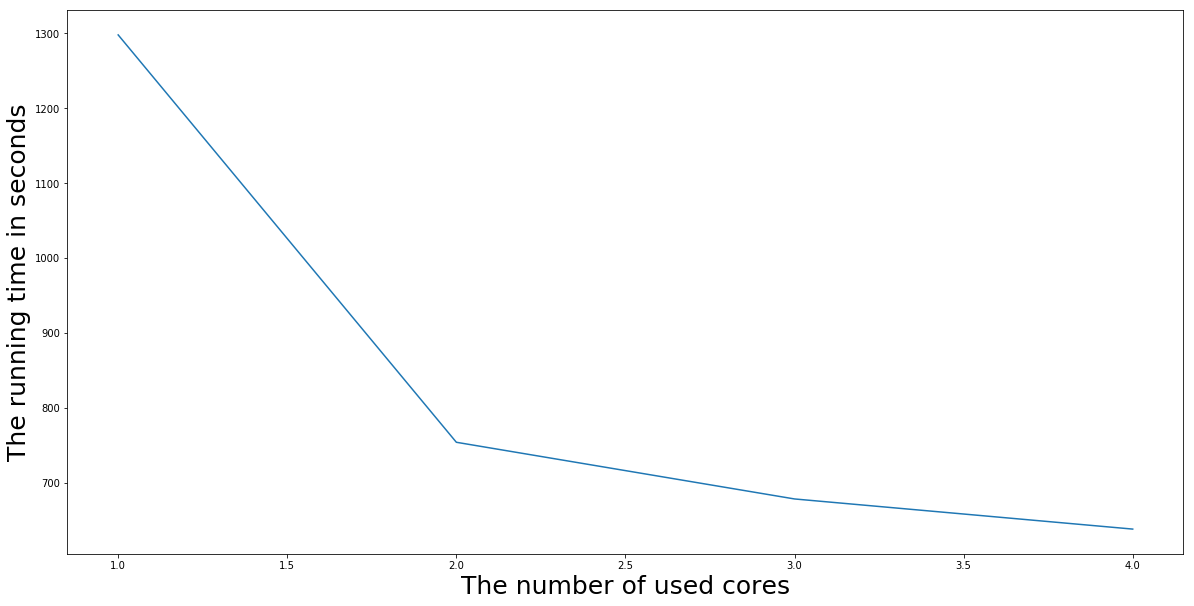

In [7]:
pyplot.figure(figsize=(20,10))
pyplot.plot([1,2,3,4],[1297.84, 753.86, 678.17, 637.93])
pyplot.xlabel('The number of used cores',fontsize=25)
pyplot.ylabel('The running time in seconds',fontsize=25)
pyplot.show()

# Thank you teachers :)